In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 13.0.1


# Phase Noise

## Introduction

Phase noise is a critical factor in the performance of Frequency-Modulated Continuous Wave (FMCW) radar systems. It refers to random variations in the phase of the transmitted signal or received echoes. These phase variations can have several significant impacts on FMCW radar operation:

1. **Range Accuracy Degradation:** Phase noise can introduce errors in the measurement of range or distance to a target. This occurs because the phase noise affects the accuracy of the frequency sweep, leading to inaccuracies in calculating the time delay of the reflected signal.

2. **Doppler Shift Errors:** FMCW radar relies on the Doppler effect to measure target velocities. Phase noise can corrupt the accuracy of Doppler measurements, leading to errors in determining the velocity of moving objects.

3. **Signal-to-Noise Ratio (SNR) Reduction:** Phase noise contributes to the overall noise level in radar signals. This can reduce the SNR, making it more challenging to detect and track targets, especially those at longer ranges.

4. **Sensitivity to Frequency Deviation:** Phase noise sensitivity is higher when the frequency deviation of the FMCW signal is small. This means that low-power radar signals with limited frequency deviation are more susceptible to phase noise effects.

5. **Mitigation Strategies:** To mitigate the impact of phase noise, radar engineers employ various techniques, such as improving the phase-locked loop (PLL) design, using high-quality oscillators, and employing signal processing methods to reduce the noise's influence on measurements.

In summary, phase noise in FMCW radar systems can introduce errors in range, velocity, and decrease SNR, potentially affecting the radar's overall performance and accuracy. Engineers must carefully manage and mitigate phase noise to ensure the radar system meets its intended objectives.

[RadarSimPy](https://radarsimx.com/radarsimx/radarsimpy/) offers support for simulating transmitter phase noise. By integrating measured phase noise data into the simulation module, users can assess how phase noise affects the performance of the radar system. Here's an illustrative example of how to incorporate phase noise into the radar module.

## Create Radar Model

### Phase Noise

The phase noise is defined by two arrays: `frequency offset (Hz)` and `power density (dB/Hz)`


In [2]:
import numpy as np

phase_noise_freq = np.array(
    [
        10000,
        10694,
        11444,
        12195,
        12945,
        13696,
        14446,
        15197,
        15947,
        16698,
        17448,
        18199,
        18949,
        19700,
        20450,
        21201,
        21951,
        22702,
        23452,
        24203,
        24953,
        25704,
        26454,
        27205,
        27956,
        28706,
        29457,
        30281,
        32536,
        34790,
        37045,
        39299,
        41554,
        43808,
        46062,
        48317,
        50571,
        52826,
        55080,
        57335,
        59589,
        61844,
        64098,
        66353,
        68607,
        70862,
        73116,
        75371,
        77625,
        79879,
        82134,
        84388,
        86643,
        88897,
        91152,
        93406,
        95661,
        97915,
        100000,
        106935,
        114440,
        121946,
        129451,
        136956,
        144461,
        151967,
        159472,
        166977,
        174482,
        181987,
        189493,
        196998,
        204503,
        212008,
        219514,
        227019,
        234524,
        242029,
        249535,
        257040,
        264545,
        272050,
        279555,
        287061,
        294566,
        302812,
        325357,
        347901,
        370446,
        392991,
        415535,
        438080,
        460625,
        483169,
        505714,
        528259,
        550803,
        573348,
        595893,
        618438,
        640982,
        663527,
        686072,
        708616,
        731161,
        753706,
        776250,
        798795,
        821340,
        843884,
        866429,
        888974,
        911518,
        934063,
        956608,
        979152,
        1000000,
        1069352,
        1144404,
        1219457,
        1294509,
        1369561,
        1444613,
        1519666,
        1594718,
        1669770,
        1744822,
        1819875,
        1894927,
        1969979,
        2045032,
        2120084,
        2195136,
        2270188,
        2345241,
        2420293,
        2495345,
        2570397,
        2645450,
        2720502,
        2795554,
        2870606,
        2945659,
        3028119,
        3253566,
        3479013,
        3704460,
        3929907,
        4155353,
        4380800,
        4606247,
        4831694,
        5057141,
        5282587,
        5508034,
        5733481,
        5958928,
        6184375,
        6409821,
        6635268,
        6860715,
        7086162,
        7311608,
        7537055,
        7762502,
        7987949,
        8213396,
        8438842,
        8664289,
        8889736,
        9115183,
        9340630,
        9566076,
        9791523,
        10000000,
        10693520,
        11444043,
        12194565,
        12945088,
        13695610,
        14446132,
        15196655,
        15947178,
        16697700,
        17448222,
        18198744,
        18949268,
        19699788,
        20450312,
        21200834,
        21951356,
        22701880,
        23452402,
        24202924,
        24953446,
        25703968,
        26454492,
        27205012,
        27955536,
        28706060,
        29456580,
        30281194,
        32535662,
        34790132,
        37044600,
        39299064,
        41553536,
        43808000,
        46062472,
        48316936,
        50571408,
        52825872,
        55080340,
        57334808,
        59589276,
        61843744,
        64098208,
        66352680,
        68607144,
        70861616,
        73116080,
        75370552,
        77625016,
        79879488,
        82133952,
        84388424,
        86642888,
        88897360,
        91151824,
        93406296,
        95660760,
        97915224,
        100000000,
    ]
)
phase_noise_power = np.array(
    [
        -74.82,
        -75.24,
        -75.59,
        -75.90,
        -76.14,
        -76.30,
        -76.38,
        -76.43,
        -76.48,
        -76.59,
        -76.78,
        -77.08,
        -77.47,
        -77.91,
        -78.38,
        -78.83,
        -79.23,
        -79.58,
        -79.89,
        -80.16,
        -80.41,
        -80.65,
        -80.91,
        -81.18,
        -81.48,
        -81.79,
        -82.10,
        -82.39,
        -82.65,
        -82.86,
        -83.01,
        -83.09,
        -83.11,
        -83.06,
        -82.98,
        -82.86,
        -82.73,
        -82.58,
        -82.44,
        -82.29,
        -82.15,
        -82.01,
        -81.86,
        -81.72,
        -81.58,
        -81.43,
        -81.29,
        -81.14,
        -81,
        -80.87,
        -80.76,
        -80.66,
        -80.58,
        -80.53,
        -80.52,
        -80.54,
        -80.60,
        -80.70,
        -80.85,
        -81.05,
        -81.31,
        -81.60,
        -81.95,
        -82.32,
        -82.72,
        -83.13,
        -83.53,
        -83.91,
        -84.28,
        -84.62,
        -84.95,
        -85.29,
        -85.65,
        -86.04,
        -86.47,
        -86.94,
        -87.44,
        -87.94,
        -88.44,
        -88.92,
        -89.37,
        -89.81,
        -90.22,
        -90.63,
        -91.05,
        -91.48,
        -91.94,
        -92.41,
        -92.91,
        -93.42,
        -93.95,
        -94.49,
        -95.04,
        -95.59,
        -96.13,
        -96.66,
        -97.17,
        -97.67,
        -98.15,
        -98.61,
        -99.04,
        -99.46,
        -99.86,
        -100.24,
        -100.62,
        -100.99,
        -101.35,
        -101.72,
        -102.08,
        -102.44,
        -102.81,
        -103.2,
        -103.59,
        -104.02,
        -104.47,
        -104.97,
        -105.5,
        -106.07,
        -106.68,
        -107.31,
        -107.96,
        -108.61,
        -109.26,
        -109.9,
        -110.51,
        -111.1,
        -111.66,
        -112.18,
        -112.65,
        -113.07,
        -113.44,
        -113.77,
        -114.06,
        -114.33,
        -114.6,
        -114.91,
        -115.27,
        -115.7,
        -116.18,
        -116.72,
        -117.29,
        -117.88,
        -118.48,
        -119.06,
        -119.64,
        -120.2,
        -120.76,
        -121.31,
        -121.85,
        -122.39,
        -122.93,
        -123.46,
        -123.97,
        -124.48,
        -124.97,
        -125.43,
        -125.88,
        -126.3,
        -126.7,
        -127.09,
        -127.44,
        -127.78,
        -128.09,
        -128.38,
        -128.64,
        -128.87,
        -129.1,
        -129.31,
        -129.52,
        -129.75,
        -130.01,
        -130.3,
        -130.62,
        -130.98,
        -131.37,
        -131.78,
        -132.19,
        -132.6,
        -132.99,
        -133.36,
        -133.71,
        -134.03,
        -134.32,
        -134.58,
        -134.82,
        -135.02,
        -135.19,
        -135.34,
        -135.45,
        -135.53,
        -135.59,
        -135.65,
        -135.71,
        -135.78,
        -135.87,
        -135.98,
        -136.12,
        -136.28,
        -136.45,
        -136.62,
        -136.78,
        -136.93,
        -137.06,
        -137.17,
        -137.27,
        -137.36,
        -137.45,
        -137.52,
        -137.59,
        -137.66,
        -137.73,
        -137.79,
        -137.84,
        -137.89,
        -137.93,
        -137.96,
        -137.97,
        -137.98,
        -137.98,
        -137.97,
        -137.96,
        -137.94,
        -137.94,
        -137.94,
        -137.96,
        -137.98,
        -138.01,
        -138.04,
        -138.05,
        -138.06,
        -138.04,
        -138.02,
        -137.96,
    ]
)

_Plot phase noise_


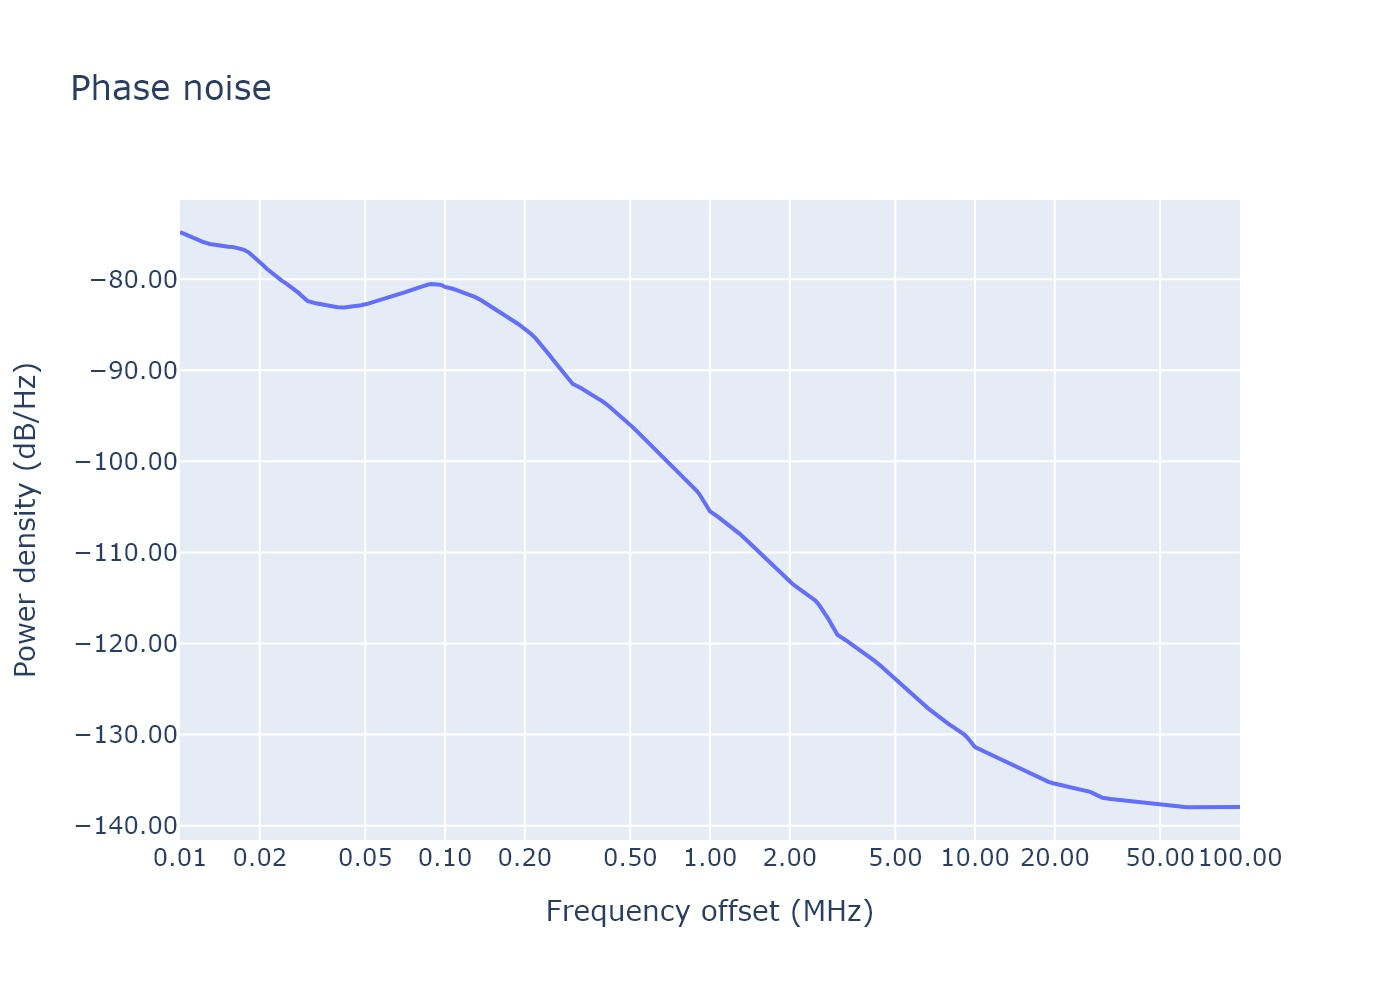

In [3]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=phase_noise_freq / 1000000,
        y=phase_noise_power,
        name="Phase noise",
    )
)
fig.update_layout(
    title="Phase noise",
    yaxis=dict(tickformat=".2f", title="Power density (dB/Hz)"),
    xaxis=dict(tickformat=".2f", title="Frequency offset (MHz)", type="log"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Transmitter

Setup the basic transmitter parameters through [Transmitter](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter) module.

For comparison, we create two transmitters:

- `tx_pn` with phase noise
- `tx` without phase noise.


In [4]:
from radarsimpy import Radar, Transmitter, Receiver

tx_channel = dict(
    location=(0, 0, 0),
)

tx_pn = Transmitter(
    f=[24.125e9 - 50e6, 24.125e9 + 50e6],
    t=80e-6,
    tx_power=20,
    prp=100e-6,
    pulses=128,
    pn_f=phase_noise_freq,
    pn_power=phase_noise_power,
    channels=[tx_channel],
)

tx = Transmitter(
    f=[24.125e9 - 50e6, 24.125e9 + 50e6],
    t=80e-6,
    tx_power=20,
    prp=100e-6,
    pulses=128,
    channels=[tx_channel],
)

### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.


In [5]:
rx_channel = dict(
    location=(0, 0, 0),
)

rx = Receiver(
    fs=2e6,
    noise_figure=12,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=[rx_channel],
)

Create the FMCW radar model based on all the parameters defined above.

- `radar_pn` with phase noise
- `radar` without phase noise


In [6]:
radar_pn = Radar(transmitter=tx_pn, receiver=rx)
radar = Radar(transmitter=tx, receiver=rx)

In [7]:
radar_pn.sample_prop["phase_noise"]

array([0.99911079-0.04216202j, 0.9993024 -0.03734587j,
       0.99975049-0.02233748j, ..., 0.99997501-0.00707015j,
       0.99988266-0.01531882j, 0.99921751-0.0395522j ], shape=(25560,))

### Targets

The propertities of targets are defined here. There are 2 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (degree).


In [8]:
target_1 = dict(location=(150, 20, 0), speed=(0, 0, 0), rcs=70, phase=0)
target_2 = dict(location=(80, -5, 0), speed=(0, 0, 0), rcs=40, phase=0)

targets = [target_1, target_2]

## Simulate Baseband Signals

Use the `simulator.sim_radar` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [9]:
from radarsimpy.simulator import sim_radar

raw_data_pn = sim_radar(radar_pn, targets)
time_matrix_pn = raw_data_pn["timestamp"]
data_matrix_pn = raw_data_pn["baseband"] + raw_data_pn["noise"]

raw_data = sim_radar(radar, targets)
time_matrix = raw_data["timestamp"]
data_matrix = raw_data["baseband"] + raw_data["noise"]

## Radar Signal Processing

### Range Profile

With an FMCW radar, the range profile of the targets could be obtained through a simple FFT across the samples of the chirp. This process is also known as the range-FFT.


In [10]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)

range_profile_pn = proc.range_fft(data_matrix_pn, range_window)
range_profile = proc.range_fft(data_matrix, range_window)

_Plot the average of the range profiles_


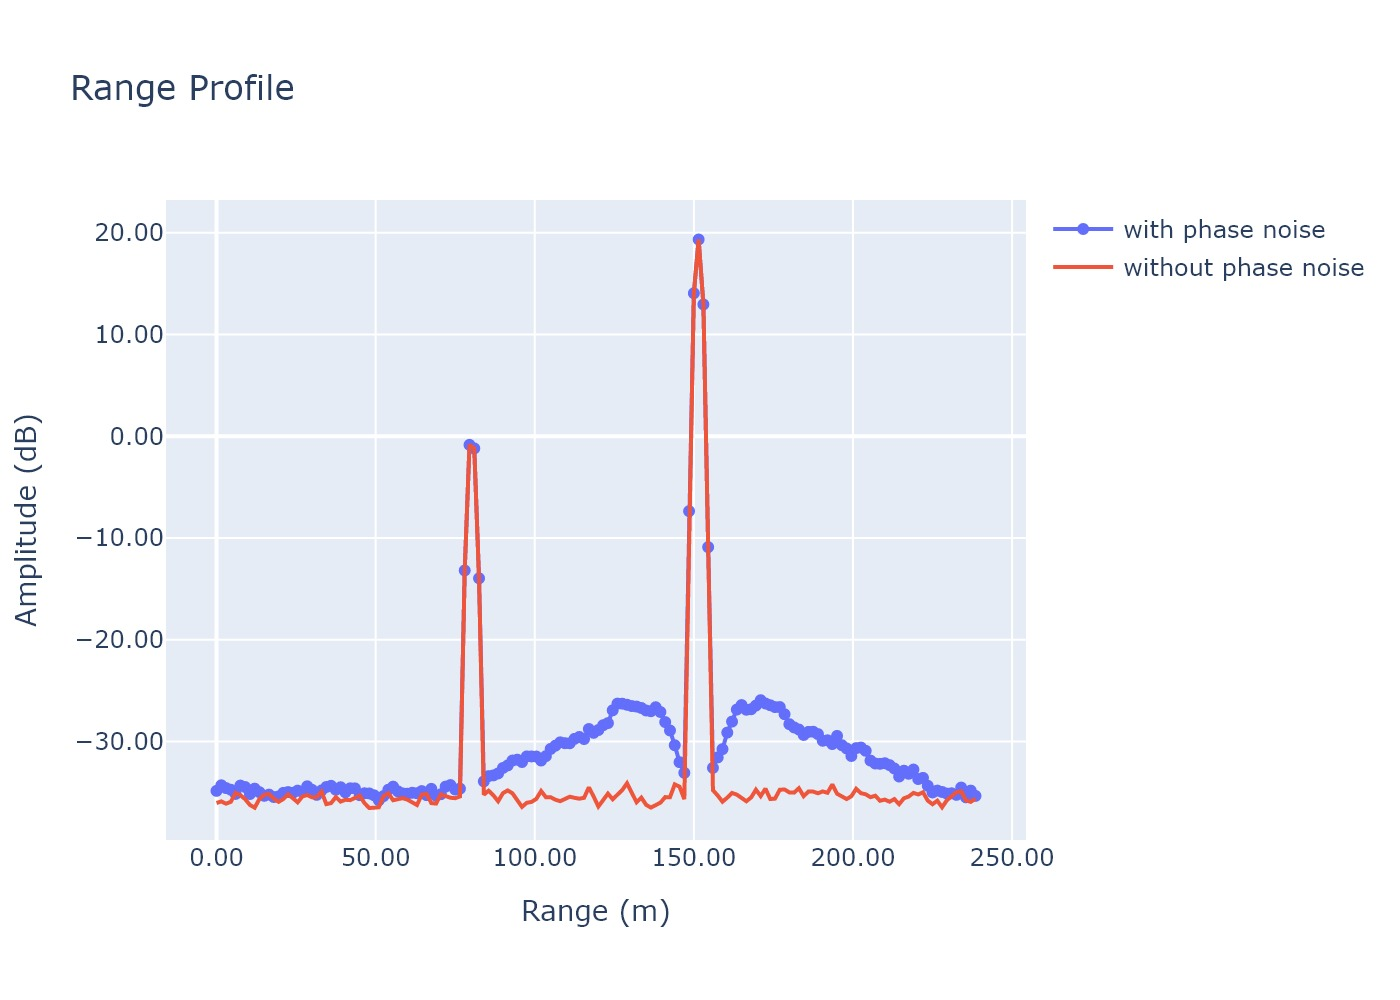

In [11]:
max_range = (
    3e8
    * radar.radar_prop["receiver"].bb_prop["fs"]
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 2
)
range_axis = np.linspace(
    0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False
)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(np.mean(np.abs(range_profile_pn[0, :, :]), axis=0)),
        mode="lines+markers",
        name="with phase noise",
    )
)

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(np.mean(np.abs(range_profile[0, :, :]), axis=0)),
        name="without phase noise",
    )
)

fig.update_layout(
    title="Range Profile",
    yaxis=dict(tickformat=".2f", title="Amplitude (dB)"),
    xaxis=dict(tickformat=".2f", title="Range (m)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

As depicted in the figure, the presence of phase noise manifests itself as additional peaks, or "shoulders," in the range profiles. Notably, these shoulders become more prominent as the target's range increases due to increased decorrelation over longer time delays.

In the context of automotive radar applications, a heightened shoulder phenomenon translates to a diminished dynamic range. This decrease in dynamic range can have practical consequences, potentially leading to scenarios where smaller targets positioned near larger ones might escape detection. For instance, a pedestrian walking in front of a moving vehicle could be obscured by these phase noise-induced shoulders, posing a safety concern.

Hence, it underscores the critical importance of maintaining low phase noise in the radar signal generator. Doing so is essential to preserve an adequate dynamic range, ensuring the radar system's ability to reliably detect and distinguish objects, especially in complex and crowded environments.
